In [1]:
%pylab inline
style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


In [2]:
from neuron import h, gui

// CVODE не работает с 

In [3]:
h.cvode_active(0)

0.0

# Using original RM03 model and interface to NEURON

In [4]:
total_capacitance = 12 # pF

soma_area = total_capacitance * 1e-6 / 1 # pF -> uF, 1 uF/cm^2
soma_diam = 1e4*sqrt(soma_area/pi) # cm->um

print 'Soma area: %02.2e cm^2, diameter: %02.2f um'%(soma_area,soma_diam)
# Isn't it a bit too large a diameter? -> No, it's OK


Soma area: 1.20e-05 cm^2, diameter: 19.54 um


In [5]:
currents = ['klt', 'kht', 'na', 'ka', 'ih', 'hcno', 'leak']

In [6]:
def ns_to_mhocm2(x):
    "Convert from nanosiemens to siemens/cm^2"
    return 1e-9*x/soma_area

In [7]:

typeII = {cond:ns_to_mhocm2(val) for cond, val in 
 [('gnabar',1000), ('gkhtbar',150), ('gkltbar', 200),
  ('gabar', 0),  ('ghbar', 20),   ('glk', 2), ]}

#typeII['glk'] = 0
typeII['Vm0'] = -63.6
# in S/cm^2
typeII

{'Vm0': -63.6,
 'gabar': 0.0,
 'ghbar': 0.0016666666666666666,
 'gkhtbar': 0.0125,
 'gkltbar': 0.016666666666666666,
 'glk': 0.00016666666666666666,
 'gnabar': 0.08333333333333334}

In [8]:
bushy = h.Section(name='bushy') 
bushy.nseg=1
bushy.diam = soma_diam
bushy.L = soma_diam
bushy.Ra = 150
bushy.cm = 1

In [9]:
for cur in currents:
    print cur
    bushy.insert(cur)

klt
kht
na
ka
ih
hcno
leak


In [10]:
bushy.ek = -70
bushy.ena = 50
bushy.gbar_hcno = 0

bushy.gnabar_na = typeII['gnabar']
bushy.gkhtbar_kht = typeII['gkhtbar']
bushy.gkltbar_klt = typeII['gkltbar']
bushy.gkabar_ka = typeII['gabar']
bushy.ghbar_ih = typeII['ghbar']
bushy.g_leak = typeII['glk']

In [11]:
h.psection(bushy)

1.0

In [12]:
v_vec = h.Vector()             # Membrane potential vector
t_vec = h.Vector()             # Time stamp vector
v_vec.record(bushy(0.5)._ref_v)
t_vec.record(h._ref_t)


1.0

In [13]:
h.v_init = typeII['Vm0']

In [14]:
h.tstop = 2000

In [15]:
h.run()

0.0

(-70, -50)

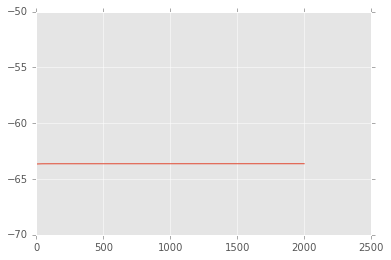

In [16]:
plot(t_vec, v_vec);
ylim(-70,-50)

In [17]:
bushy.v

-63.630838279934736

In [18]:
seg = bushy(0.5)

In [19]:
seg.ih.i*0.2 + seg.ina

-0.0010694863362850284

In [20]:
seg.ih.i*0.8 + seg.ik

0.0008412913208071804

In [21]:
gnar = seg.ina/(seg.v-seg.ena)  # Siemens/cm^2
gkr = seg.ik/(seg.v-seg.ek)
ghr = seg.i_ih/(seg.v- -43)
glkr = seg.leak.i/(seg.v -seg.erev_leak)


Rin_t2 = 71.0 # From Rothman and Manis 2003

# From model:
Ginx = (gnar + gkr + ghr + glkr)* seg.area()*1e-8
Rin_t2x = 1e-6/Ginx 

print Rin_t2, 'in cit., in model:', Rin_t2x, 'MOhm'

71.0 in cit., in model: 71.0797445221 MOhm


In [22]:
R = 8314.4  # Universal gaz constant, mJ / mole*K
F = 96485   # Faraday constant [C/mol]
F_ATP = 50 # kJ/mol

avogadro = 6.022e23 # N_a

In [23]:
def ratp_atwell(V, Rin, Ena = 50, Ek = -70):
    "returns resting ATP consumption rate in pmol ATP/s"
    # I take Rm in MOhms and V in mV
    # Thus, result is in nmole/sec
    out = (Ena-V)*(V-Ek)/(F*Rin*(V + 2*Ena - 3*Ek))
    return out*1e3 # nmol -> pmol

def pmol2molecules(x):
    return x*1e-12*avogadro

def atp2J(nATP):
    "Convert pmol ATP/s to energy usage in pJoule/s"
    return F_ATP * nATP * 1e3
    pas

def nJ2atp(nJ):
    "convert from nJoule/s to nmol ATP/s"
    return (nJ/F_ATP)*1e-3

## Оценка затрат в покое по Attwell и по Moujahid&D'Anjou

In [24]:
def mouj_Erate(seg, Iap=0, erev_ih = -43):
    v = seg.v
    acc = Iap*v
    acc += seg.ina*(v-seg.ena) 
    acc += seg.ik*(v-seg.ek)
    acc += seg.i_leak*(v-seg.erev_leak)
    acc += seg.ih.i*(v-erev_ih)
    factor = (1e-8) # um^2 -> cm^2
    factor *= (1e6) #-> pJ/s
    return acc*seg.area()*factor

def hasegawa_Erate(seg, Iap=0,erev_ih = -43):
    v = seg.v
    acc = Iap*v
    acc -= seg.ina*seg.ena 
    acc -= seg.ik*seg.ek
    acc -= seg.i_leak*seg.erev_leak
    acc -= seg.ih.i*erev_ih
    factor = (1e-8) # um^2 -> cm^2
    factor *= (1e6) #-> pJ/s
    return acc*seg.area()*factor

In [25]:
rATP_bushy  = ratp_atwell(bushy.v, Rin_t2x, Ek=-70)

print\
"""Оценка по Attwell: {:.3e} pmol ATP/сек
                 : {:.3e} pJ/s""".format(rATP_bushy, atp2J(rATP_bushy))

Оценка по Attwell: 4.283e-04 pmol ATP/сек
                 : 2.142e+01 pJ/s


In [26]:
dH_bushy2 = mouj_Erate(bushy(0.5))
dH_bushy3 = hasegawa_Erate(bushy(0.5))

rATP_bushy2 = nJ2atp(dH_bushy2)
rATP_bushy3 = nJ2atp(dH_bushy3)

In [27]:
print\
"""Оценка по Moujahid & D'Anjou: {:.3e} pmole ATP/сек
                            : {:.3e} pJ/s""".format(rATP_bushy2, dH_bushy2)

Оценка по Moujahid & D'Anjou: 3.414e-05 pmole ATP/сек
                            : 1.707e+00 pJ/s


In [28]:
print\
"""Оценка по Hasegawa: {:.3e} pmole ATP/сек
                  : {:.3e} pJ/s""".format(rATP_bushy3, dH_bushy3)

Оценка по Hasegawa: 3.414e-05 pmole ATP/сек
                  : 1.707e+00 pJ/s


Attwell to Moujahid ratio:

In [29]:
rATP_bushy/rATP_bushy2

12.547091696369389

In [30]:
def split_ih(seg, gratio=4, eh=-43):
    "splits ih to Na and K components (crude)"
    v = seg.v
    gnah = seg.ih.i/(v*(gratio+1) - gratio*seg.ek - seg.ena)
    inah = gnah*(v-seg.ena)
    ikh = gratio*gnah*(v-seg.ek)
    return inah, ikh

In [31]:
inah, ikh = split_ih(seg)
print inah, ikh

jk = (bushy.ik + ikh)*soma_area/F # mmol/s
jna = (bushy.ina + inah)*soma_area/F

## В текущей модели, получается, что jk=jna, что сложно совместимо
## со стехиометрией Na,K-АТФ-азы

print allclose(jk,jna)

jatp_na = -jna/3
jatp_k = jk/2


print '%0.3e'%(jatp_na*1e9), 'pmol ATP/s [from jNa]'
print '%03e'%(jatp_k*1e9), 'pmol ATP/s [from jK]'

-0.00646478280355 0.00144943917634
True
2.708e-04 pmol ATP/s [from jNa]
3.919576e-04 pmol ATP/s [from jK]


А это близко к тому, что дает оценка по  Attwell (хотя бы по порядку величин)...



**Можем ли мы найти такой ток, при котором iNa:iK = 3:2 в стационарном состоянии?** -> Это будет током ipump

In [32]:
istim = h.IClamp(bushy(0.5))

In [33]:
istim.delay = 0.01
istim.dur = 10000
amps = linspace(-1,1,10)
amps = concatenate([amps, linspace(-0.25,0.25,100)])
amps = sorted(amps)
cur_ratio = []
vrest = []
h.tstop = 2000
for amp in amps:
    istim.amp = amp
    h.run()
    inah,ikh = split_ih(seg)
    ina = (bushy.ina + inah)
    ik = (bushy.ik + ikh)
    vrest.append(seg.v)
    cur_ratio.append(ina/ik)

(-1, 1)

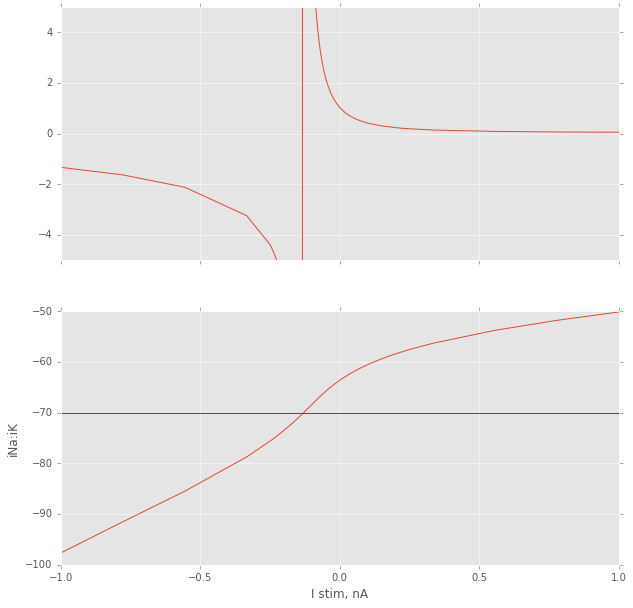

In [34]:
f, axs = subplots(2,1,sharex=True,figsize=(10,10))
axs[0].plot(amps, -array(cur_ratio))
setp(axs[0], ylim=(-5,5))
ylabel('iNa:iK')
axs[1].plot(amps, vrest)
axs[1].axhline(-70, color='m')
xlabel('I stim, nA')
xlim(-1,1)


In [35]:
Icut= amps[argmin((array(vrest)+70)**2)]
Icut

-0.12878787878787878

In [36]:
istim.delay = 0.01
istim.dur = 20000
#amps = linspace(-1,1,10)
amps = linspace(-0.04, -0.01, 100)
amps = sorted(amps)
cur_ratio = []
vrest = []
h.tstop = 10000
for amp in amps:
    istim.amp = amp
    h.run()
    inah,ikh = split_ih(seg)
    ina = (bushy.ina + inah)
    ik = (bushy.ik + ikh)
    vrest.append(seg.v)
    cur_ratio.append(ina/ik)

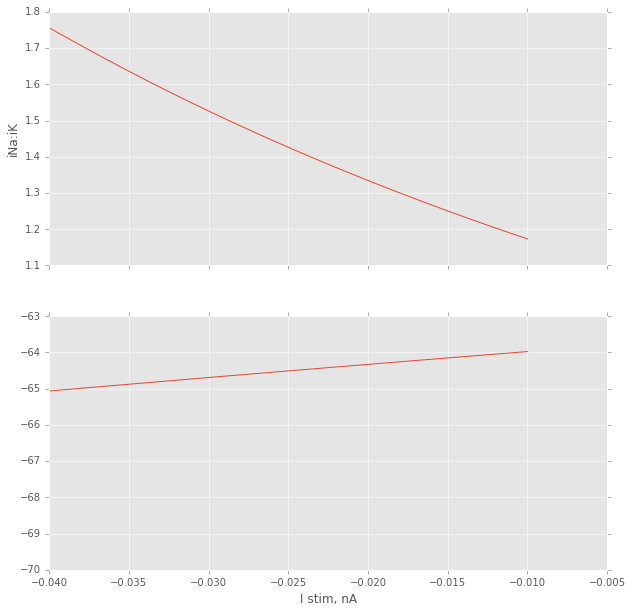

In [37]:
f, axs = subplots(2,1,sharex=True,figsize=(10,10))
axs[0].plot(amps, -array(cur_ratio))
setp(axs[0],  ylabel='iNa:iK')
axs[1].plot(amps, vrest)
axs[1].axhline(-70, color='m')
xlabel('I stim, nA')

Ipump получился -0.029 nA


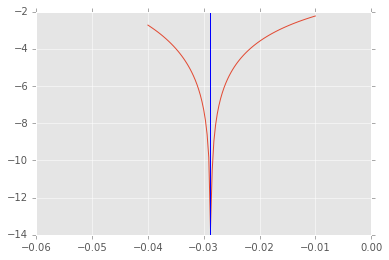

In [38]:
cr = -array(cur_ratio)
score = (cr-1.5)**2
plot(amps, log(score))
ip = amps[argmin(score)]
axvline(ip)
#ylim(-20,0)
xlim(-0.06, 0)

print 'Ipump получился %.3f nA'%ip

In [39]:
'New estimate: %.3e'%((-ip/F)*1e3), 'pmole ATP/s'

('New estimate: 2.984e-04', 'pmole ATP/s')

In [40]:
ip

-0.028787878787878789

In [41]:
istim.amp = ip
h.v_init=-60
h.tstop=10000
h.dt = 0.025


h.run()

0.0

In [42]:
print seg.v

inah, ikh = split_ih(seg)

print 'Current ratio:', -(inah + bushy.ina) / (ikh + bushy.ik)
print 'Sum current:', (inah + bushy.ina) + (ikh+bushy.ik)

-64.6630366783
Current ratio: 1.50313913037
Sum current: -0.0024551592356


In [43]:
ipumpx = -(inah + bushy.ina)*soma_area/(F*3)

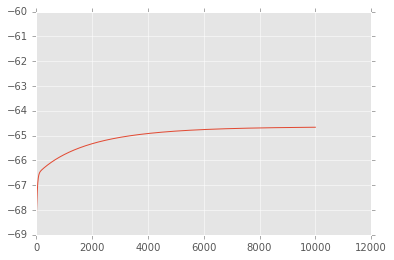

In [44]:
plot(t_vec, v_vec)

**Note** Только за эти времена токи уже устаканиваются, поэтому долго считать. Надо что ли алгебраически вывести...

In [45]:
dH_bushy2 = mouj_Erate(bushy(0.5),ip)
dH_bushy3 = hasegawa_Erate(bushy(0.5),ip)

rATP_bushy2 = nJ2atp(dH_bushy2)
rATP_bushy3 = nJ2atp(dH_bushy3)

In [46]:
print\
"""Оценка по Moujahid & D'Anjou: {:.3e} pmole ATP/сек
                            : {:.3e} pJ/s""".format(rATP_bushy2, dH_bushy2)

Оценка по Moujahid & D'Anjou: 4.834e-04 pmole ATP/сек
                            : 2.417e+01 pJ/s


In [47]:
print\
"""Оценка по Hasegawa: {:.3e} pmole ATP/сек
                  : {:.3e} pJ/s""".format(rATP_bushy3, dH_bushy3)

Оценка по Hasegawa: 4.462e-04 pmole ATP/сек
                  : 2.231e+01 pJ/s


In [48]:
print 'Новая оценка по Attwell-like: %.3e'%((ipumpx*1e9)), 'pmol ATP/s'

Новая оценка по Attwell-like: 3.041e-04 pmol ATP/s


Ну что же, теперь хотя бы порядок величин совпадает.

## Исправляем оценку по Муджахиду (23.03.2016)

Обнаружил недостаток в том, как мы оценивали затраты энергии по Moujahid: неявно предполагалось, что когда $V = E_h$, то $I_h$ не тратит энергию, но это не так: он одновременно использует $E_Na$ и $E_K$, потому что пропускает оба иона. Попробуем разложить этот ток на Na и К составляющие, и использовать их в подсчете энергозатрат по методу Moujahid.


In [49]:
istim.amp = 0
h.run()

0.0

In [50]:
def mouj_Erate2(seg, Iap=0, erev_ih = -43):
    v = seg.v
    acc = Iap*v
    inah, ikh = split_ih(seg) # раскладываем Ih на компоненты
    ina = seg.ina + inah      # суммарный ток Na
    ik = seg.ik + ikh         # суммарный ток K
    acc += ina*(v-seg.ena) 
    acc += ik*(v-seg.ek)
    acc += seg.i_leak*(v-seg.erev_leak) # Ну и утечка, хотя вклад от нее минимальный
    factor = (1e-8) # um^2 -> cm^2
    factor *= (1e6) #-> pJ/s
    return acc*seg.area()*factor

In [51]:
dH_bushy2a = mouj_Erate2(bushy(0.5))
#dH_bushy3 = hasegawa_Erate(bushy(0.5),ip)

rATP_bushy2a = nJ2atp(dH_bushy2a)
#rATP_bushy3 = nJ2atp(dH_bushy3)

In [52]:
print\
"""Оценка по Moujahid & D'Anjou #2(a): {:.3e} pmole ATP/сек
                                  : {:.3e} pJ/s""".format(rATP_bushy2a, dH_bushy2a)

Оценка по Moujahid & D'Anjou #2(a): 1.872e-04 pmole ATP/сек
                                  : 9.358e+00 pJ/s


Мы получили меньше, чем в оценке по Attwell, но зато не добавляем искуственный "ток через Na/K насос", чтобы добиться нулевого суммарного потока Na и К через мембрану в модели предполагая, что любые discrepancies компенсируются потоками этих ионов, не рассматриваемых в модели напрямую.

In [53]:
istim.amp = ip
h.run()
dH_bushy2b = mouj_Erate2(bushy(0.5),ip)
rATP_bushy2b = nJ2atp(dH_bushy2b)

print\
"""Оценка по Moujahid & D'Anjou (2b): {:.3e} pmole ATP/сек
                                 : {:.3e} pJ/s""".format(rATP_bushy2b, dH_bushy2b)

Оценка по Moujahid & D'Anjou (2b): 6.549e-04 pmole ATP/сек
                                 : 3.274e+01 pJ/s


In [54]:
1e-6*0.03/soma_area

0.0024999999999999996

При добавлении и гиперполяризующего тока $\approx -0.03$ nA ($0.0025$ mA/cm^2) энаргозатраты выросли (с учетом тока) почти в 3.5 раза.

** Но что выбрать, оценку по Moujahid или Hasegawa, и есть ли разница?**

In [55]:
def hasegawa_Erate2(seg, Iap=0,erev_ih = -43):
    v = seg.v
    acc = Iap*v
    inah, ikh = split_ih(seg) # раскладываем Ih на компоненты
    ina = seg.ina + inah      # суммарный ток Na
    ik = seg.ik + ikh         # суммарный ток K
    acc -= ina*seg.ena 
    acc -= ik*seg.ek
    acc -= seg.i_leak*seg.erev_leak
    factor = (1e-8) # um^2 -> cm^2
    factor *= (1e6) #-> pJ/s
    return acc*seg.area()*factor

In [56]:
istim.amp =0
h.run()

dH_bushy3a = hasegawa_Erate2(bushy(0.5))
rATP_bushy3a = nJ2atp(dH_bushy3a)

In [57]:
print\
"""Оценка по Hasegawa (2a): {:.3e} pmole ATP/сек
                       : {:.3e} pJ/s""".format(rATP_bushy3a, dH_bushy3a)

Оценка по Hasegawa (2a): 1.872e-04 pmole ATP/сек
                       : 9.358e+00 pJ/s


Ожидаемо, что в состоянии покоя ($I_{app}=0$) разницы между Hasegawa и Moujahid нет.

In [58]:
istim.amp = ip
h.run()
dH_bushy3b = hasegawa_Erate2(bushy(0.5),ip)
rATP_bushy3b = nJ2atp(dH_bushy3b)

print\
"""Оценка по Hasegawa (2b): {:.3e} pmole ATP/сек
                       : {:.3e} pJ/s""".format(rATP_bushy3b, dH_bushy3b)

Оценка по Hasegawa (2b): 6.176e-04 pmole ATP/сек
                       : 3.088e+01 pJ/s


Но и при небольшом гиперполяризующем токе разница также не столь значительна.